In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
# @title Параметры
# PATH_TO_DATA = "dummy_df.joblib"  # <-- provide path
PATH_TO_DATA = "/content/drive/MyDrive/stocks/Data/DOGEUSDT/raw_data/DOGEUSDT_1m_2024-01-01_to_2025-05-23.joblib"
START = "2024-01-20"
END = "2025-05-23"
TIMESTAMP_COL = "timestamp"          # column with timestamps
EMA_FAST_PERIOD = 500
EMA_SLOW_PERIOD = 750
SPLITS = (0.7, 0.15, 0.15)

SEQ_LEN = 14
BATCH_SIZE = 256
UNITS_PER_LAYER = [128, 128, 64]
DROPOUT = 0.3
EPOCHS = 10
LR = 3e-5
GRAD_CLIP_NORM = 1.0
EARLY_STOPPING_PATIENCE = 10
LR_MODE = "onecycle"
ONECYCLE_MAX_LR = 3e-6
ONECYCLE_PCT_START = 0.5
LR_RESTART_PATIENCE = 4
LR_RESTART_SHRINK = 0.5
BEST_PATH = "best_lstm.weights.h5"


In [2]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from drive.MyDrive.stocks.pretrained_rl_ppo.scr.check_data import prepare_time_series
from drive.MyDrive.stocks.pretrained_rl_ppo.scr.calibrate import calibrate_model
from drive.MyDrive.stocks.pretrained_rl_ppo.scr.q_labels_matching import enrich_q_labels_trend_one_side
from drive.MyDrive.stocks.pretrained_rl_ppo.scr.visualisation import plot_enriched_actions_one_side
from drive.MyDrive.stocks.pretrained_rl_ppo.scr.dataset_builder import DatasetBuilderForYourColumns
from drive.MyDrive.stocks.pretrained_rl_ppo.scr.residual_lstm import build_stacked_residual_lstm
from drive.MyDrive.stocks.pretrained_rl_ppo.scr.train_eval import fit_model, plot_history_curves, evaluate_dataset, confusion_and_f1_on_dataset, materialize_metrics, predict_logits_dataset
from drive.MyDrive.stocks.pretrained_rl_ppo.scr.backtest_env import BacktestEnv, EnvConfig, run_backtest_with_logits
from drive.MyDrive.stocks.pretrained_rl_ppo.scr.indicators import *

# from scr.check_data import prepare_time_series
# from scr.calibrate import calibrate_model
# from scr.q_labels_matching import enrich_q_labels_trend_one_side
# from scr.visualisation import plot_enriched_actions_one_side
# from scr.dataset_builder import DatasetBuilderForYourColumns
# from scr.residual_lstm import build_stacked_residual_lstm
# from scr.train_eval import fit_model, plot_history_curves, evaluate_dataset, confusion_and_f1_on_dataset, materialize_metrics, predict_logits_dataset
# from scr.backtest_env import BacktestEnv, EnvConfig, run_backtest_with_logits
# from scr.indicators import *


In [3]:
# Load and check data
raw_df = joblib.load(PATH_TO_DATA).loc[START:END]
df = prepare_time_series(raw_df, timestamp_col=TIMESTAMP_COL)
print(f"From {df.index[0]} to {df.index[-1]}")


From 2024-01-20 00:00:00+00:00 to 2025-05-23 23:59:00+00:00


In [4]:
# Add indicators
close = df['Close'].to_numpy(np.float64)
high = df['High'].to_numpy(np.float64)
low = df['Low'].to_numpy(np.float64)
volume = df['Volume'].to_numpy(np.float64)

df['EMA_fast_raw'] = ema_numba(close, EMA_FAST_PERIOD)
df['EMA_slow_raw'] = ema_numba(close, EMA_SLOW_PERIOD)
df['EMA_fast'] = ema_numba_safe(close, EMA_FAST_PERIOD)
df['EMA_slow'] = ema_numba_safe(close, EMA_SLOW_PERIOD)
df['SMA_14'] = sma_numba(close, 14)
df['ADX_14'] = adx_numba(high, low, close, 14)
df['ATR_14'] = atr_numba(high, low, close, 14)
df['RSI_14'] = rsi_numba(close, 14)
macd, macd_signal, macd_hist = macd_numba(close, 12, 26, 9)
df['MACD'] = macd
df['MACD_signal'] = macd_signal
df['MACD_hist'] = macd_hist
stoch_k, stoch_d = stoch_numba(high, low, close, 14, 3)
df['STOCH_K'] = stoch_k
df['STOCH_D'] = stoch_d
boll_mid, boll_up, boll_dn = bollinger_numba(close, 20, 2.0)
df['BOLL_MID'] = boll_mid
df['BOLL_UP'] = boll_up
df['BOLL_DN'] = boll_dn
df['OBV'] = obv_numba(close, volume)
df['CCI_20'] = cci_numba(high, low, close, 20)
df['WILLR_14'] = williams_r_numba(high, low, close, 14)
df['MFI_14'] = mfi_numba(high, low, close, volume, 14)
df['ROC_12'] = roc_numba(close, 12)
df['VWAP_20'] = vwap_numba(high, low, close, volume, 20)
piv = zigzag_pivots_highlow_numba(high, low, close, 0.05, -0.05, 3, 1)
df['Pivots'] = piv
df['Pivots_expanded'] = expand_pivots(piv, 2)


In [6]:
# Добавляем сигнал референс стратегии
buy_sig  = (df['EMA_fast'] > df['EMA_slow']) & (df['Close'] > df['EMA_fast']) & (df['ADX_14'] > 20)
sell_sig = (df['EMA_fast'] < df['EMA_slow']) & (df['Close'] < df['EMA_fast']) & (df['ADX_14'] > 20)
df['Signal_Rule'] = np.where(buy_sig, 1, np.where(sell_sig, -1, 0)).astype(np.int8)


In [7]:
# Q-labels
df = enrich_q_labels_trend_one_side(
    df,
    # mode='tdlambda',
    # H_max = 100,
    # lam = 0.99,

    # mode='horizon',
    # H_max = 30,

    mode='exit',

    use_mae_penalty=False,
)
print(df[100:150].to_string())


        timestamp     Open     High      Low    Close     Volume  EMA_fast_raw  EMA_slow_raw  EMA_fast  EMA_slow    SMA_14     ADX_14    ATR_14     RSI_14      MACD  MACD_signal     MACD_hist     STOCH_K    STOCH_D  BOLL_MID   BOLL_UP   BOLL_DN        OBV      CCI_20    WILLR_14     MFI_14    ROC_12   VWAP_20  Pivots  Pivots_expanded  Signal_Rule  Pos  Q_Open  Q_Close     Q_Hold  Q_Wait  Mask_Open  Mask_Close  Mask_Hold  Mask_Wait
100  1.705715e+12  0.07883  0.07883  0.07874  0.07876   539792.0      0.078517      0.078512  0.078517  0.078512  0.078836  30.805949  0.000082  52.541337  0.000087     0.000091 -4.080487e-06   39.024390  61.944300  0.078746  0.079048  0.078444  -650214.0   16.888014  -60.975610  52.977913  0.000000  0.078773       0                0            1    1     NaN      0.0 -54.596245     NaN          0           1          1          0
101  1.705715e+12  0.07876  0.07881  0.07874  0.07875   962446.0      0.078518      0.078512  0.078518  0.078512  0.078840  29.297

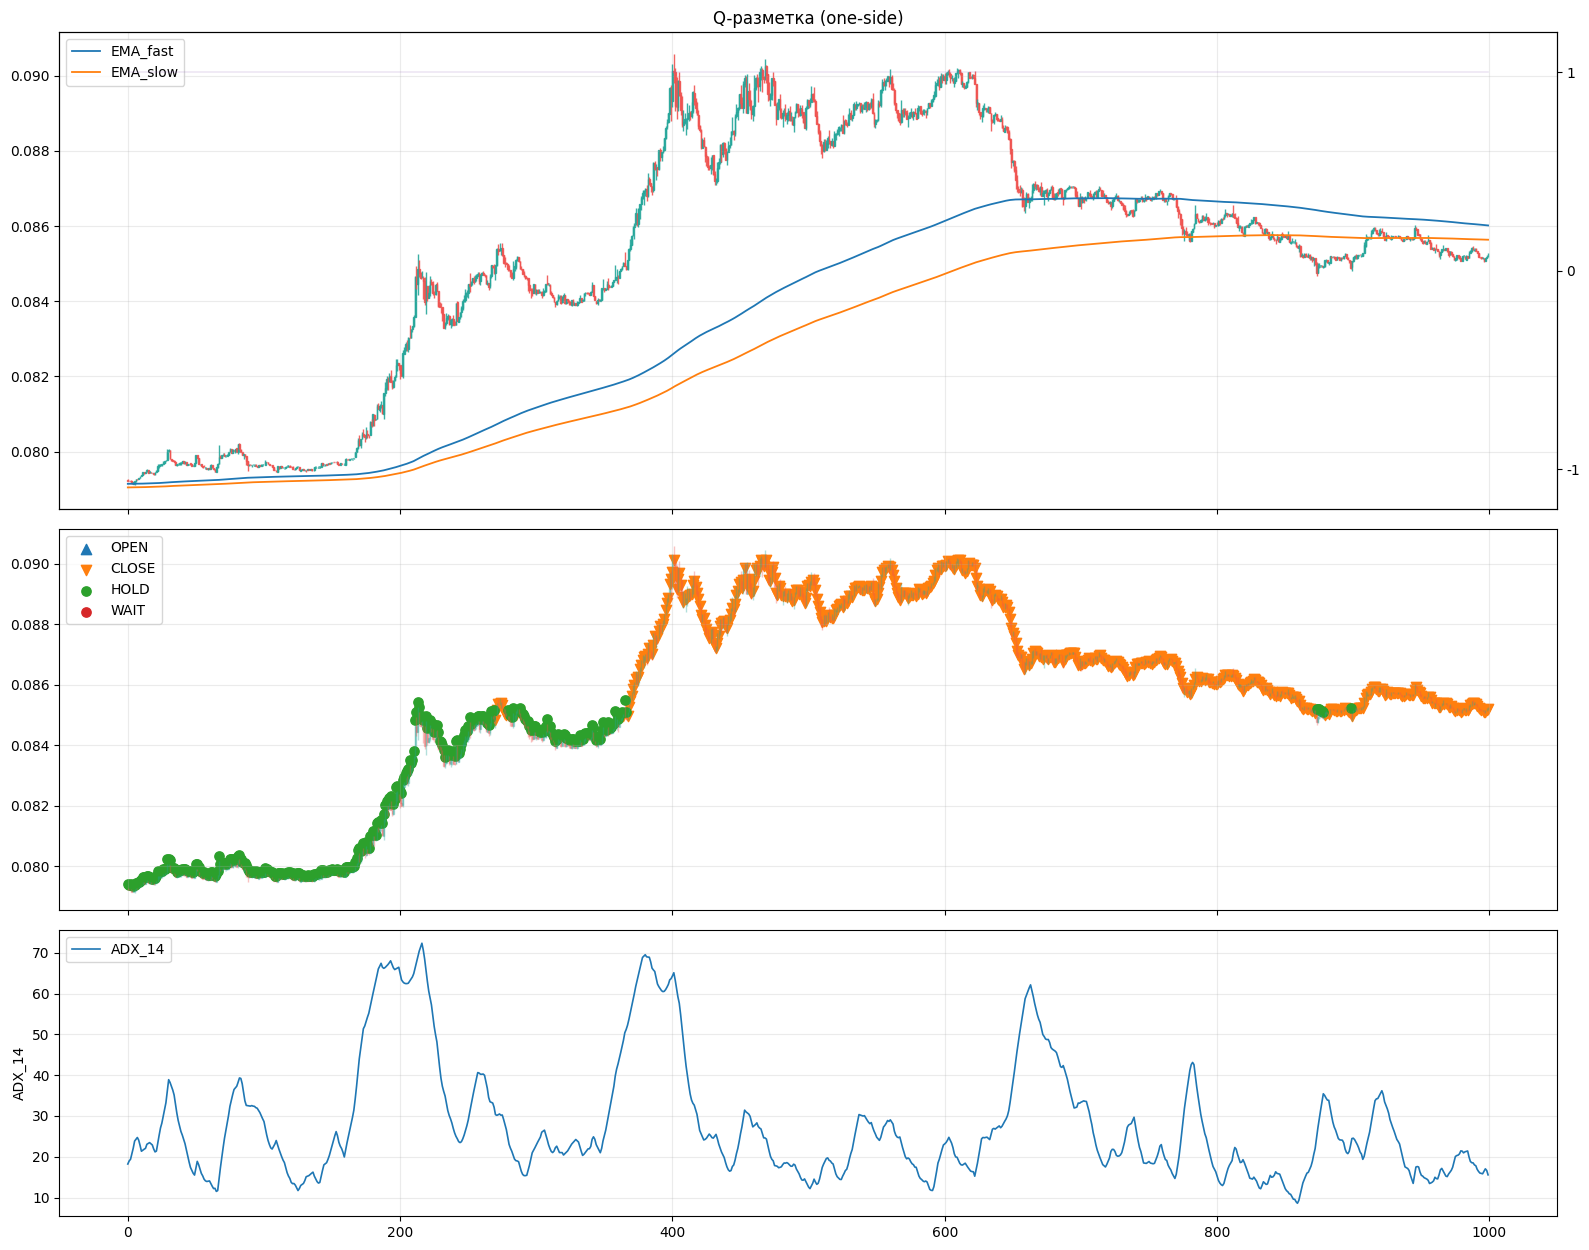

In [8]:
# Visualisation
plot_enriched_actions_one_side(
    df,
    start=1000,
    end=2000,
    indicators_price={
        'EMA_fast':df['EMA_fast'],
        'EMA_slow':df['EMA_slow'],
        },
    indicators_panels={
        'ADX_14':df['ADX_14'],
    }
)


In [15]:
# @title Нормализация и нарезка данных
enriched = df
builder = DatasetBuilderForYourColumns(
    seq_len=SEQ_LEN, norm="minmax",
    labels_from="q",
    tau=1.0, r_mode="oracle",
    splits=SPLITS,
    batch_size=BATCH_SIZE,
    sw_mode="ClassBalance",
    drop_cols=["timestamp", "BarsToExit_Open", "BarsToExit_Hold", "Signal_Rule", "Pos" ],
)
splits = builder.fit_transform(enriched, return_indices=True)
train_ds, val_ds, test_ds = builder.as_tf_datasets(splits)
test_idx = splits["test"][-1]


Epoch 01 | train: loss 0.7971, acc 0.5029, ER 75.994720 | val: loss 0.6927, acc 0.5894, macroF1 0.2300, ER -7.105866, ICp 0.5412, ICs 0.5257
Epoch 02 | train: loss 0.7535, acc 0.5049, ER 67.193100 | val: loss 0.6837, acc 0.5988, macroF1 0.2278, ER -6.246250, ICp 0.5518, ICs 0.5341
Epoch 03 | train: loss 0.7432, acc 0.5059, ER 65.626945 | val: loss 0.6745, acc 0.6024, macroF1 0.2323, ER -5.509370, ICp 0.5596, ICs 0.5389
Epoch 04 | train: loss 0.7361, acc 0.5066, ER 65.726089 | val: loss 0.6695, acc 0.6038, macroF1 0.2354, ER -5.157084, ICp 0.5652, ICs 0.5422
Epoch 05 | train: loss 0.7319, acc 0.5070, ER 65.419266 | val: loss 0.6670, acc 0.6037, macroF1 0.2408, ER -5.014377, ICp 0.5679, ICs 0.5439
Epoch 06 | train: loss 0.7280, acc 0.5065, ER 65.142830 | val: loss 0.6658, acc 0.6032, macroF1 0.2468, ER -4.996245, ICp 0.5698, ICs 0.5454
Epoch 07 | train: loss 0.7250, acc 0.5082, ER 65.235420 | val: loss 0.6660, acc 0.6004, macroF1 0.2526, ER -5.013907, ICp 0.5720, ICs 0.5463
Epoch 08 | tr

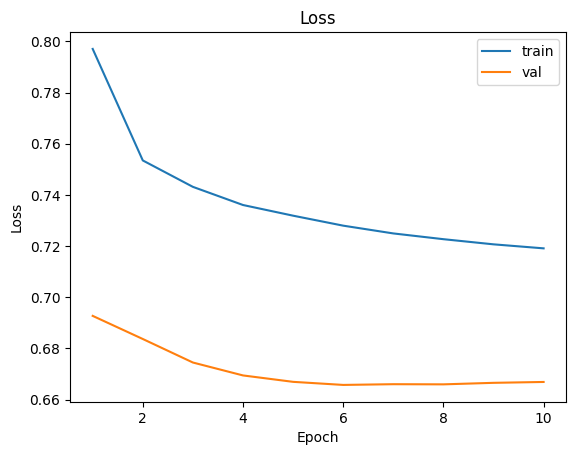

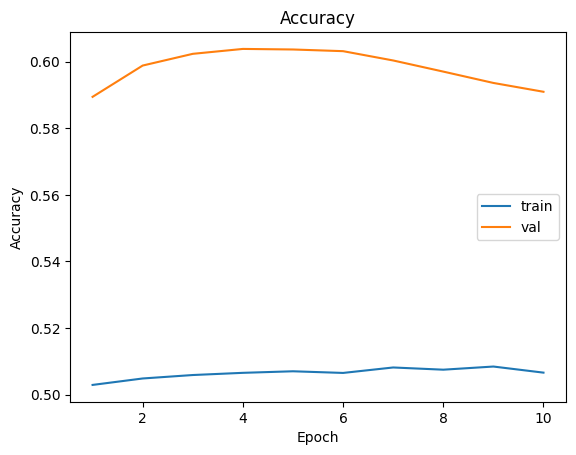

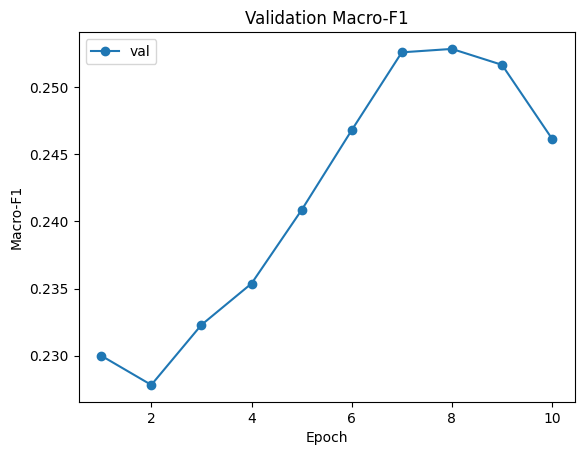

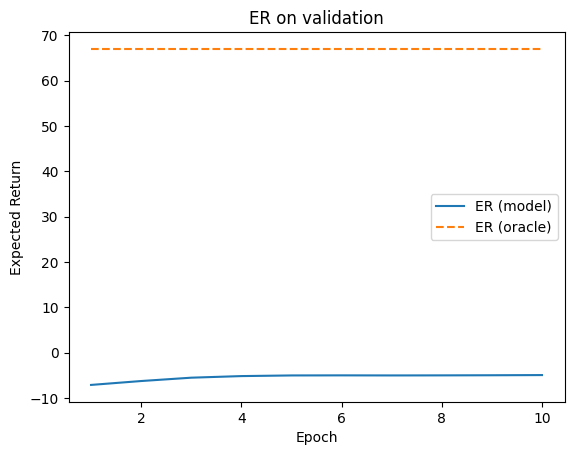

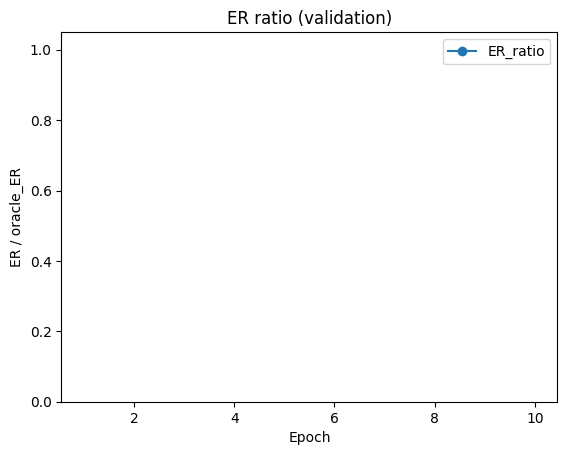

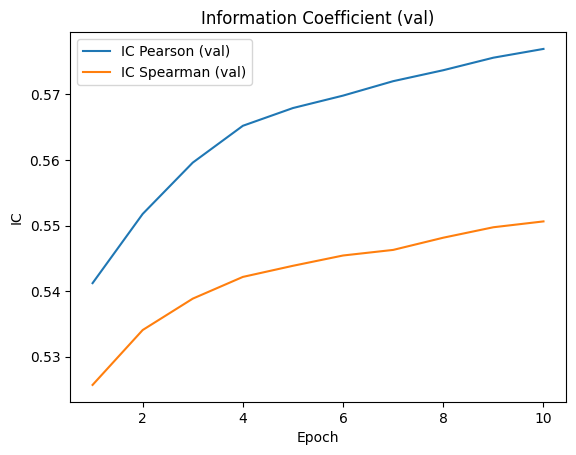

In [16]:
# @title Обучение модели
xb, _ = next(iter(train_ds.take(1)))
model = build_stacked_residual_lstm(seq_len=xb.shape[1], feature_dim=xb.shape[-1],
                                    units_per_layer=UNITS_PER_LAYER, dropout=DROPOUT)

history = fit_model(
    model,
    train_ds,
    val_ds,
    epochs=EPOCHS,
    steps_per_epoch=None,
    lr=LR,
    grad_clip_norm=GRAD_CLIP_NORM,
    early_stopping_patience=EARLY_STOPPING_PATIENCE,
    lr_mode=LR_MODE,
    onecycle_max_lr=ONECYCLE_MAX_LR,
    onecycle_pct_start=ONECYCLE_PCT_START,
    lr_restart_patience=LR_RESTART_PATIENCE,
    lr_restart_shrink=LR_RESTART_SHRINK,
    best_path=BEST_PATH,
)

plot_history_curves(history)


In [17]:
# 3) оценка на тесте
test_metrics = evaluate_dataset(model, test_ds)
print("TEST METRICS:")
for k,v in  materialize_metrics(test_metrics).items():
  print(f"{k}:{v}")


TEST METRICS:
loss:0.6879572868347168
acc:0.5472705364227295
macro_f1:0.2156519591808319
f1_per_class:[0.1138092428445816, 0.3958698511123657, 0.001423365785740316, 0.3515053689479828]
exp_return:33.64870834350586
oracle_ER:143.5941925048828
ER_ratio:0.23433196544647217
IC_pearson:0.6191135048866272
IC_spearman:0.5953915119171143


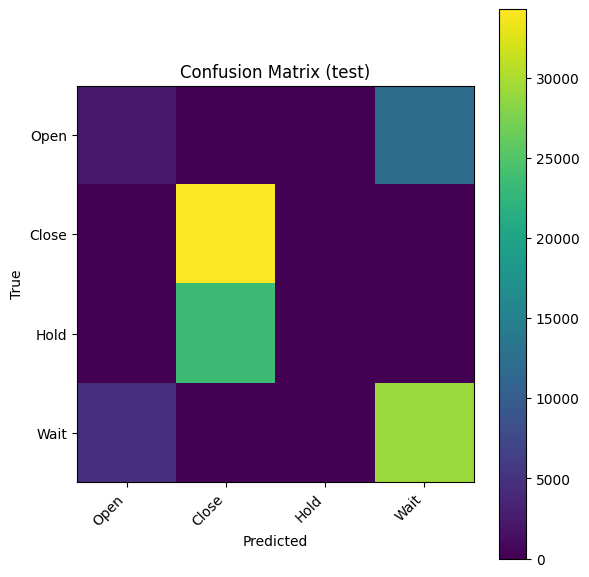

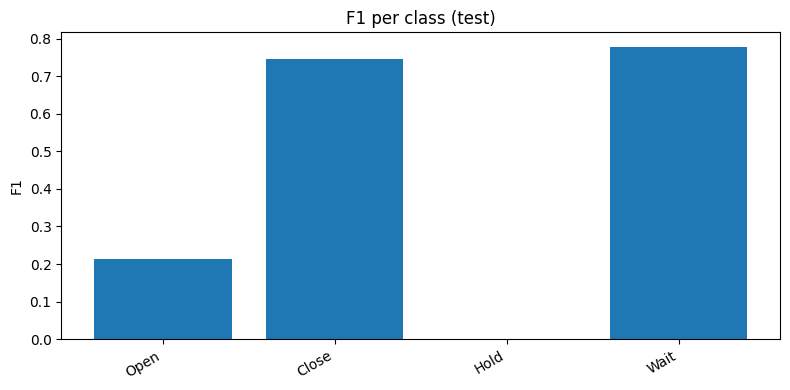

In [18]:
# 4) конфьюжн-матрица и F1 per class на тесте
cm_test, f1_test = confusion_and_f1_on_dataset(model, test_ds)

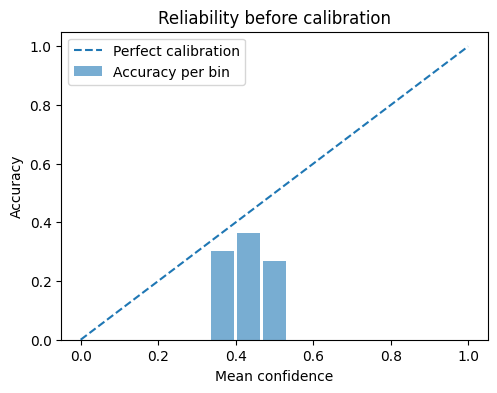

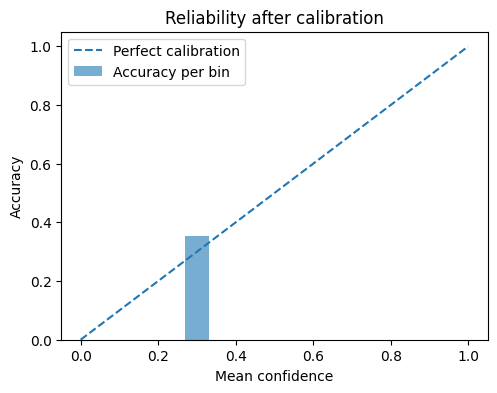

NLL before: 1.433773 | ECE before: 0.068617
NLL after:  1.342749 | ECE after:  0.056958
Temperature T: [11.544198  57.84563    1.6698364  3.8725345]
Saved: artifacts/calibration/temperature.json
Температуры:  [11.544198036193848, 57.84563064575195, 1.669836401939392, 3.8725345134735107]


In [19]:
# Калибровка модели
calib_info = calibrate_model(model, val_ds, per_class=True, init_T=1.0, plot=True)
T = calib_info['T']
print("Температуры: ", T)


Метрики референс стратегии:
Equity: 0.4718
Realized PnL: 0.4718
Closed trades: 53
Win rate: 32.08%
Avg PnL per trade: 0.0090
Profit factor: 1.9531
Max drawdown: 5.3534
Sharpe ratio: 1.4021

Метрики модели:
Equity: 0.0000
Realized PnL: 0.0000
Closed trades: 0
Win rate: 0.00%
Avg PnL per trade: 0.0000
Profit factor: 0.0000
Max drawdown: 0.0000
Sharpe ratio: 0.0000

Метрики учителя:
Equity: -11.1457
Realized PnL: -11.1457
Closed trades: 18208
Win rate: 28.58%
Avg PnL per trade: -0.0005
Profit factor: 0.2308
Max drawdown: 0.0000
Sharpe ratio: -66.6711


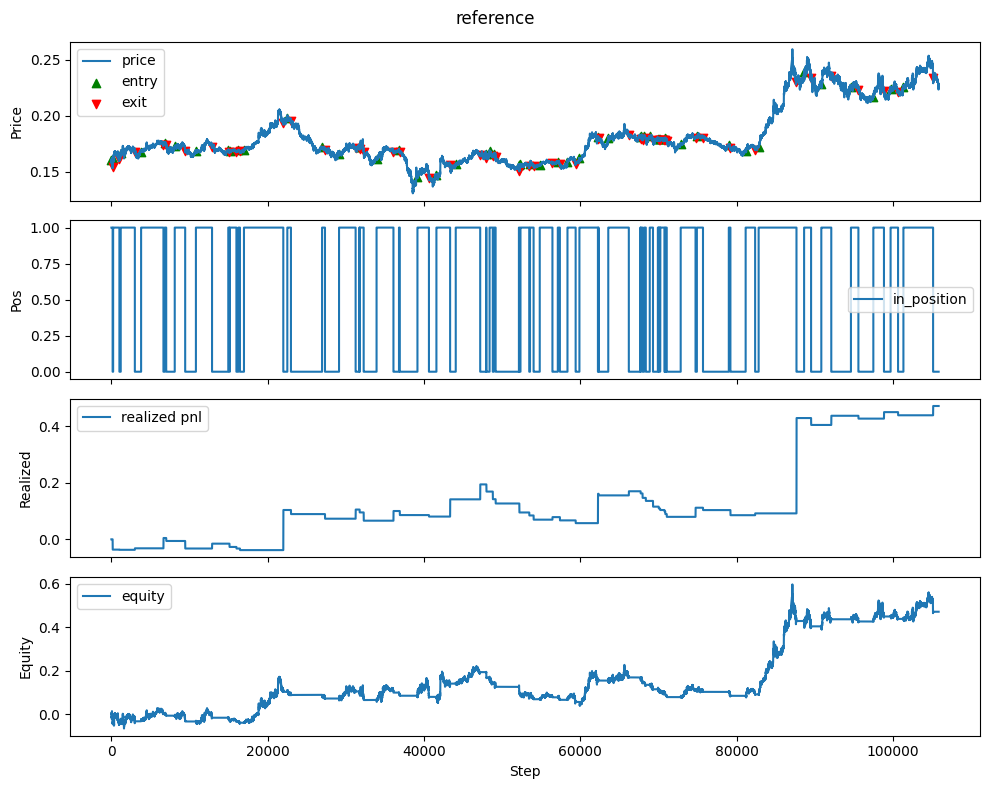

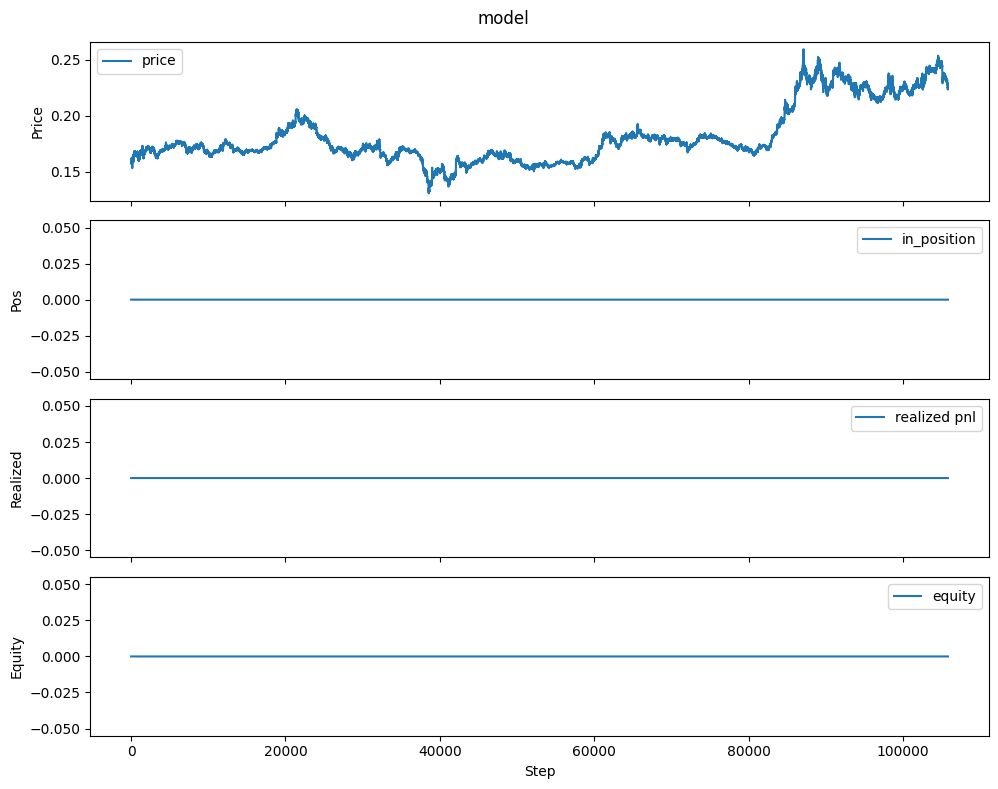

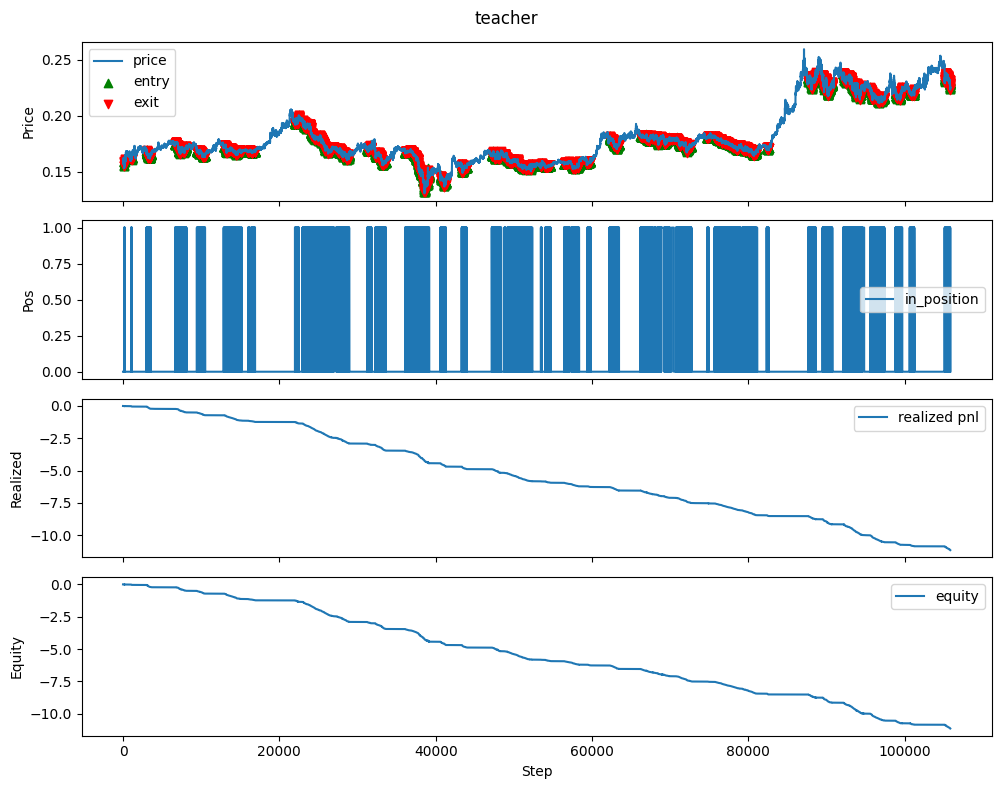

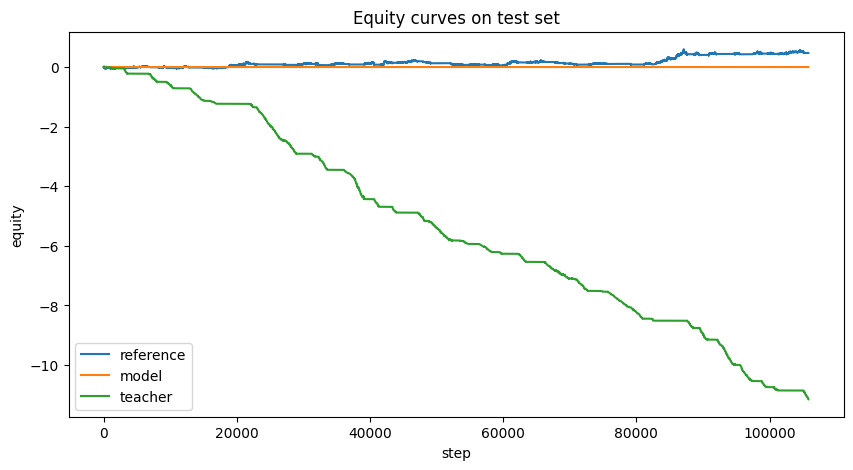

In [20]:
#Запуск бэктестов: референс стратегия, модель, учитель


def run_backtest(df, environment):
    env = environment
    env.reset()
    for sig in df['Signal_Rule'].iloc[:-1]:
        pos = env.position
        if sig == 1:
            action = 1
        elif sig == -1:
            action = 2
        else:
            action = 3 if pos == 1 else 0
        _, _, done, _ = env.step(action)
        if done:
            break
    return env

LONG_CONFIG = EnvConfig(
    mode=1,          # работаем только от длинной позиции
    fee=0.0002,         # без комиссии
    spread=0.0001,      # без спреда
    leverage=1.0,    # без плеча
    max_steps=10**9, # практически бесконечный эпизод
    reward_scale=1.0,# без масштабирования вознаграждения
    use_log_reward=False, # линейная доходность
    time_penalty=0.0,     # нет штрафа за удержание
    hold_penalty=0.0,     # нет штрафа за бездействие
)

start, end = int(test_idx[0]), int(test_idx[-1])
df_bt = enriched.iloc[start:end+2].copy()

env_ref = BacktestEnv(df_bt, feature_cols=['EMA_fast', 'EMA_slow'], cfg=LONG_CONFIG, price_col='Open')
sim_ref = run_backtest(df_bt, env_ref)
sim_ref.plot("reference")
print('Метрики референс стратегии:')
print(sim_ref.metrics_report())

logits = predict_logits_dataset(model, test_ds)
logits_cal = logits / T
env_model = run_backtest_with_logits(enriched, logits_cal, test_idx, feature_cols=['EMA_fast', 'EMA_slow'], price_col='Open', cfg=LONG_CONFIG)
env_model.plot("model")
print('\nМетрики модели:')
print(env_model.metrics_report())

W_test = splits['test'][3]
env_teacher = run_backtest_with_logits(enriched, W_test, test_idx, feature_cols=['EMA_fast', 'EMA_slow'], price_col='Open', cfg=LONG_CONFIG)
env_teacher.plot("teacher")
print('\nМетрики учителя:')
print(env_teacher.metrics_report())

log_ref = sim_ref.logs()
log_model = env_model.logs()
log_teacher = env_teacher.logs()
plt.figure(figsize=(10,5))
plt.plot(log_ref['equity'], label='reference')
plt.plot(log_model['equity'], label='model')
plt.plot(log_teacher['equity'], label='teacher')
plt.legend()
plt.title('Equity curves on test set')
plt.xlabel('step')
plt.ylabel('equity')
plt.show()
